In [239]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [240]:
class Env():

    def __init__(self, rows, cols, cliff_row, cliff_length):
        self.rows = rows
        self.cols = cols
        self.cliff_row = min(cliff_row,self.rows-1)
        self.cliff_length = min(cliff_length, self.cols-1)
        self.grid = np.zeros(rows*cols).reshape(rows,cols)
        for j in range(1, self.cliff_length):
            self.grid[self.cliff_row][j] = -1
        self.grid[self.rows-1][self.cols-1] = 2
        self.grid[self.rows-1][0] = 1
        self.start_spot = [self.rows-1,0]

        self.step_penalty = -1
        self.cliff_penalty = -100
        self.reward = -1
        self.goal_state = [self.rows-1,self.cols-1]

    def give_reward(self, old_pos, action):
        new_pos = old_pos.copy()
        new_pos[0] -= action[0]
        new_pos[1] += action[1]

        if new_pos[0] < 0:
            new_pos[0] = 0
        if new_pos[1] < 0:
            new_pos[1] = 0
        if new_pos[0] > self.rows-1:
            new_pos[0] = self.rows-1
        if new_pos[1] > self.cols-1:
            new_pos[1] = self.cols-1

        grid_spot_val = self.grid[new_pos[0],new_pos[1]]

        if grid_spot_val == -1:
            reward = self.cliff_penalty
            new_pos = [self.rows-1,0]
            #print('cliff)')
        elif (grid_spot_val == 0) or (grid_spot_val == 1):
            reward = self.step_penalty
            #print('valid')
        elif grid_spot_val == 2:
            reward = self.reward
            #print('complete')

        return reward, new_pos    
        





In [241]:
testenv = Env(3,4,2,3)

[2, 3]


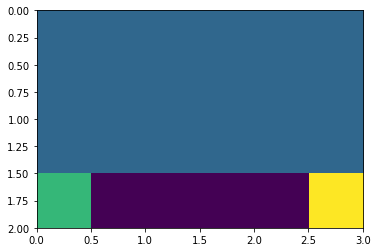

In [242]:
print(testenv.goal_state)
plt.imshow(testenv.grid)
plt.xlim(left = 0, right=3)
plt.ylim(bottom=2, top = 0)
plt.show;

In [243]:
all_actions = list()

all_actions.append([1,0])
all_actions.append([-1,0])
all_actions.append([0,1])
all_actions.append([0,-1])

all_actions

[[1, 0], [-1, 0], [0, 1], [0, -1]]

In [244]:
from audioop import reverse
from enum import unique


class Agent():

    def __init__(self, epsilon, alpha,grid_shape , method = 'S', acts_allowed = all_actions ):
        self.epsilon = epsilon
        self.alpha = alpha
        self.grid_shape = grid_shape
        self.method = method
        self.step_count = 0
        self.avail_actions = acts_allowed.copy()
        self.position = [self.grid_shape[0]-1,0]
        self.q_table = np.zeros(self.grid_shape[0]*self.grid_shape[1]*len(self.avail_actions)).reshape(self.grid_shape[0],self.grid_shape[1],len(self.avail_actions))
        self.meta_rewards = list()
        self.meta_positions = list()
        self.meta_actions = list()
        self.meta_step_count = list()
        self.q_counts = np.copy(self.q_table)
        self.episode_count = 0
        self.total_rew_per_ep = list()
        

    def update_meta_lists(self, rewards, positions, actions, step_count):
        self.meta_rewards.append(rewards)
        self.meta_positions.append(positions)
        self.meta_actions.append(actions)
        self.meta_step_count.append(step_count)
        self.total_rew_per_ep.append(sum(rewards))

    def generate_avail_actions(self, pos):
        #Check the boundries of the grid
        avail_acts = self.avail_actions.copy()
        #if pos[0] == 0:
         #   avail_acts.remove([1,0])
        #if pos[0] == (self.grid_shape[0]-1):
         #   avail_acts.remove([-1,0])
        #if pos[1] == 0:
        #    avail_acts.remove([0,-1])
        #if pos[1] == (self.grid_shape[1]-1):
        #    avail_acts.remove([0,1])
        #print("available actions", avail_acts)
        return avail_acts    

    def q_learning_table_update(self, reward, action, old_pos, new_pos):
        x1 = old_pos[0]
        x2 = new_pos[0]
        y1 = old_pos[1]
        y2 = new_pos[1]
        act_ind = self.avail_actions.index(action)
        self.q_counts[x1,y1,act_ind] += 1
        # Q(s,a) <- Q(s,a) + alpha[R + gamma*max(Q(st+1,a)) - Q(s,a)]
        
        #calculating q-table max value in new position
        next_avail_acts = self.generate_avail_actions(new_pos)
        next_avail_acts_indics = list()
        for i in range(0,len(self.avail_actions)):
            if self.avail_actions[i] in next_avail_acts:
                next_avail_acts_indics.append(i)
        new_qas_max = np.max(self.q_table[x2, y2,np.r_[next_avail_acts_indics]])

        #updating our current qas value

        self.q_table[x1,y1,act_ind] += self.alpha*(reward + new_qas_max -self.q_table[x1,y1, act_ind])

    def choose_action(self, pos,step_actions, return_index = False):
        cutoff = (1-self.epsilon) * 10000
        roll = np.random.randint(1,10001)

        if roll <= cutoff:
            #greedy action
            #print('Greedy')
            avail_indics = list()
            for i in range(0,len(self.avail_actions)):
                if self.avail_actions[i] in step_actions:
                    avail_indics.append(i)
            #print('avail_indics to choose action', avail_indics)
            avail_qas = self.q_table[ pos[0],pos[1], np.r_[avail_indics]]
            #print('qas considered', avail_qas)
            max_qa_ind = np.argmax(avail_qas)
            #print('argmax of this', max_qa_ind)
            max_indis = list()
            for j in range(0,len(avail_qas)):
                if avail_qas[j] == avail_qas[max_qa_ind]:
                    max_indis.append(j)
            #print('indexes of this value in qas', max_indis)
            ind_of_inds = np.random.randint(0,len(max_indis))
            #print('one we choose randomly', ind_of_inds)
            action_index = max_indis[ind_of_inds]
           # print('action index at this ind of ind', action_index)
            action = step_actions[action_index]
           # print('action chose', action)
            
            if return_index:
                return action_index
            else:
                return action
        
        else: #exploration action
            #print('explore')
            rand_act_index = np.random.randint(0,len(step_actions))
            action = step_actions[rand_act_index]
            #print('explore action', action)
            if return_index:
                return rand_act_index
            else:
                return action
            
    def sarsa_table_update(self, reward, action, old_pos, new_pos):
        x1 = old_pos.copy()[0]
        #print('x1',x1)
        x2 = new_pos.copy()[0]
        #print('x2',x2)
        y1 = old_pos.copy()[1]
        #print('y1',y1)
        y2 = new_pos.copy()[1]
        #print('y2',y2)
        #print('Action',action)
        act_ind = self.avail_actions.index(action)
        #print('act_ind', act_ind)
        self.q_counts[x1,y1,act_ind] += 1
        #print('q_counts table', self.q_counts[x1,y1,act_ind])
        # Q(s,a) <- Q(s,a) + alpha[R + gamma*Q(st+1,at+1) - Q(s,a)]
        
        #generate available actions in new position, choose one following epsilon greedy, take q value
        next_avail_acts = self.generate_avail_actions(new_pos)
        #print('next avail actions', next_avail_acts)
        next_act = self.choose_action(new_pos,next_avail_acts)
        #print('next_act', next_act)
        next_act_ind = self.avail_actions.index(next_act)
        #print('Index of next available action', next_act_ind )
        new_qas_val = self.q_table[x2, y2,next_act_ind]
        #print('next state qas value', new_qas_val)

        #updating our current qas value

        self.q_table[x1,y1,act_ind] += self.alpha*(reward + new_qas_val -self.q_table[x1,y1,act_ind])

    def expec_sarsa_table_update(self, reward, action, old_pos, new_pos):
        x1 = old_pos.copy()[0]
        x2 = new_pos.copy()[0]
        y1 = old_pos.copy()[1]
        y2 = new_pos.copy()[1]
        act_ind = self.avail_actions.index(action)
        self.q_counts[x1,y1,act_ind] += 1

        num_acts = len(self.avail_actions)
        max_qas = np.max(self.q_table[x2,y2]) #find the greedy choice value
        max_qas_list = list() 
        for i in self.q_table[x2,y2]:
            if i == max_qas:
                max_qas_list.append(i)   #create list of actions at that greedy choise value -- just need the count
        greedy_weighted_prob = (1-self.epsilon)/(len(max_qas_list))   #each action at the greedy level has an equal chance of getting picked in the greedy scenario so greedy prob/num of greedy acts
        next_qas_list = list(self.q_table[x2,y2])
        next_qas_list.sort(reverse=True)   #sort our available state-action values so we can multiply the correct probabilities
        qas_probas = list()
        for i in range(0,num_acts):
            qas_probas.append((self.epsilon*(1/num_acts)))   #everyone has an equal chance under exploration so baseline self.epsilon/number of possible actions
        for i in range(0,len(max_qas_list)):
            qas_probas[i] += greedy_weighted_prob     #the greedy actions also have the probability of being selected in the greedy scenario
    

        expec_next_qas_val = 0
        for i in range(0,len(next_qas_list)):
            expec_next_qas_val += qas_probas[i] * next_qas_list[i]   #multiply each probability and qas and add to the expected value
        
        
        self.q_table[x1,y1,act_ind] += self.alpha*(reward + expec_next_qas_val -self.q_table[x1,y1,act_ind])
    
    
    def navigate_grid(self, grid):
        rewards = list()
        positions = list()
        actions_taken = list()
        step_count = 0
        self.position = [grid.rows-1, 0]
        old_pos = self.position.copy()
        #print('start spot', self.position)
        done = False
        while not(done):
            positions.append(list(old_pos))
            step_actions = self.generate_avail_actions(old_pos)
         #   print('Step Actions', step_actions)
            action = self.choose_action(old_pos, step_actions)
          #  print('Action', action)
            actions_taken.append(list(action))
            reward, new_pos = grid.give_reward(old_pos,action)
           # print('Reward and New Position', reward, new_pos)
            rewards.append(reward)
            if self.method == 'S':
                self.sarsa_table_update(reward, action, old_pos, new_pos)
            #    print('Q-Count table at this state', self.q_counts[old_pos[0],old_pos[1]])
            elif self.method == 'Q':
                self.q_learning_table_update(reward,action,old_pos, new_pos)
            elif self.method == 'E':
                self.expec_sarsa_table_update(reward,action, old_pos, new_pos)
            old_pos = new_pos.copy()
            #print('new pos', old_pos)
            step_count += 1
            if (new_pos == grid.goal_state):# or (step_count > 35):
                done = True
                break
            #elif reward == -100:
                #done = True
                #break
            else:
                pass
        
        positions.append(list(new_pos)) #add the final position
        self.update_meta_lists(rewards, positions, actions_taken, step_count)
        self.episode_count += 1   


    def reset(self, cleanse_q_table = False):
        self.episode_count = 0
        if cleanse_q_table:
            self.q_table = np.zeros(self.grid_shape[0]*self.grid_shape[1]*len(self.avail_actions)).reshape(self.grid_shape[0],self.grid_shape[1], len(self.avail_actions))
            self.q_counts = np.copy(self.q_table)
        else:
            pass
    
    def return_trajectory(self, grid):
        path = list()
        path_actions = list()
        not_finished = True
        position = list([grid.rows-1,0])
        
        path.append(list(position))
        while not_finished:
            #print('Position', position)
            best_act_ind = np.argmax(self.q_table[position[0],position[1]])
            path_action = self.avail_actions[best_act_ind] #this is the optimal action taken at this location

            path_actions.append(list(path_action))
            #print('action selected',path_action)
            position[0] -= path_action[0]
            position[1] += path_action[1]
            #print('new pos', position)
            path.append(list(position))
            #print('Current trajectory', path)
            if (grid.grid[position[0], position[1]] == 2):
                not_finished = False
                break
        x_path = list()
        y_path = list()   

        for i in range(0,len(path)):
            x_path.append(path[i][1])
            y_path.append(path[i][0])
            
        return x_path, y_path

    def plot_trajectory(self, x_path, y_path, grid, hide_ax = True):
        if self.method == 'S':
            color_code = 'blue'
        else:
            color_code = 'red'
        sns.scatterplot(x=x_path, y=y_path, color=color_code, estimator=np.max)
        plt.imshow(grid.grid)
        if hide_ax:
            plt.axis('off')
        plt.show;


    def print_stats(self):

        print('Average Rewards', sum(self.total_rew_per_ep)/self.episode_count)
        print('Average Episode Length', sum(self.meta_step_count)/self.episode_count)

        total_rewards = list()
        for i in range(0,len(self.meta_rewards)):
            total_rewards.append(sum(self.meta_rewards[i]))
        highest_reward_episode = max(total_rewards)

        print("Highest Total Reward Achieved", highest_reward_episode)

        


In [245]:
test_agent = Agent(.1,.1, [3,4], 'S', all_actions)

In [246]:
while test_agent.episode_count < 500:
    test_agent.navigate_grid(grid= testenv)

In [247]:
test_agent.print_stats()

Average Rewards -14.276
Average Episode Length 9.326
Highest Total Reward Achieved -5


In [248]:
xp, yp = test_agent.return_trajectory(grid=testenv)
print(xp)
print(yp)

[0, 0, 0, 1, 2, 3, 3, 3]
[2, 1, 0, 0, 0, 0, 1, 2]


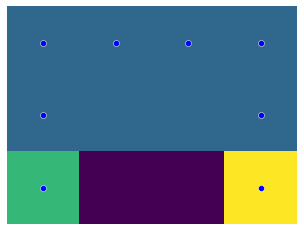

In [249]:
test_agent.plot_trajectory(xp,yp,grid=testenv)

In [250]:
test_agent_Q = Agent(.1,.1,[3,4],'Q',all_actions)

In [251]:
while test_agent_Q.episode_count < 500:
    test_agent_Q.navigate_grid(grid=testenv)

In [252]:
test_agent_Q.print_stats()

Average Rewards -18.724
Average Episode Length 7.438
Highest Total Reward Achieved -5


In [253]:
xpq, ypq = test_agent_Q.return_trajectory(testenv)

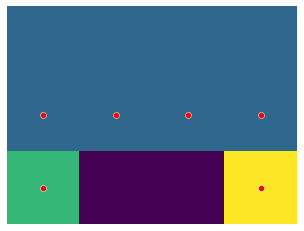

In [254]:
test_agent_Q.plot_trajectory(xpq,ypq,testenv)

In [255]:
fullenv = Env(4,12,4,11)

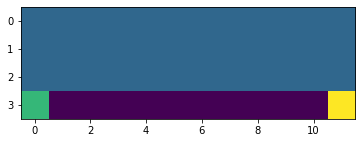

In [256]:
plt.imshow(fullenv.grid)
plt.show;

In [407]:
s_agent = Agent(.1,.1,[4,12],'S',all_actions)
q_agent = Agent(.1,.1,[4,12],'Q', all_actions)

In [413]:

while s_agent.episode_count<5000:
    s_agent.navigate_grid(grid=fullenv)
while q_agent.episode_count<5000:
    q_agent.navigate_grid(grid=fullenv)

In [414]:
sxp, syp = s_agent.return_trajectory(grid=fullenv)
qxp, qyp = q_agent.return_trajectory(grid=fullenv)

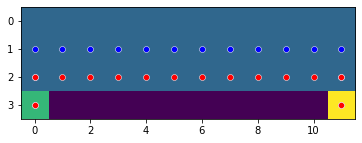

In [415]:
sns.scatterplot(x=sxp, y=syp, color='blue')
sns.scatterplot(x=qxp, y=qyp, color = 'red')
plt.imshow(fullenv.grid)
plt.imshow;

In [416]:
x_axis = np.arange(1,5001)

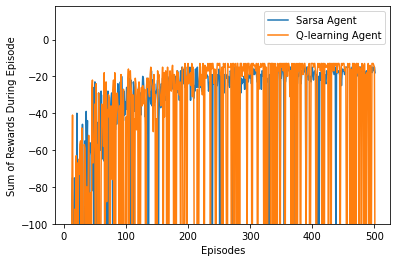

In [417]:
sns.lineplot(x=x_axis[10:501], y=s_agent.total_rew_per_ep[10:501])
sns.lineplot(x=x_axis[10:501], y=q_agent.total_rew_per_ep[10:501])
plt.xlabel('Episodes')
plt.ylabel('Sum of Rewards During Episode')
plt.ylim(bottom=-100)
plt.legend(labels=['Sarsa Agent', 'Q-learning Agent'])
plt.show;

In [267]:
s_agent_list = list()
for i in range(0,100):
    s_agent_list.append(Agent(.1,.1,[4,12],'S',all_actions))

In [268]:
q_agent_list = list()
for i in range(0,100):
    q_agent_list.append(Agent(.1,.1,[4,12],'Q',all_actions))   

In [269]:
s_agents_average_rewards = list()
q_agents_average_rewards = list()

In [270]:
for agent in range(0,len(s_agent_list)):
    while s_agent_list[agent].episode_count < 500:
        s_agent_list[agent].navigate_grid(grid=fullenv)

In [271]:
for agent in range(0,len(q_agent_list)):
    while q_agent_list[agent].episode_count < 500:
        q_agent_list[agent].navigate_grid(grid=fullenv)

In [272]:
s_agents_avg_rew_per_ep = list()
q_agents_avg_rew_per_ep = list()

In [273]:
for indic in range(0,500):
    sub_list = list()
    for agent in s_agent_list:
        sub_list.append(agent.total_rew_per_ep[indic])
    s_agents_avg_rew_per_ep.append(list(sub_list))

In [274]:
for indic in range(0,500):
    sub_list = list()
    for agent in q_agent_list:
        sub_list.append(agent.total_rew_per_ep[indic])
    q_agents_avg_rew_per_ep.append(list(sub_list))

In [275]:
for i in range(0,len(s_agents_avg_rew_per_ep)):
    s_agents_avg_rew_per_ep[i] = sum(s_agents_avg_rew_per_ep[i])/len(s_agents_avg_rew_per_ep[i])

In [276]:
for i in range(0,len(q_agents_avg_rew_per_ep)):
    q_agents_avg_rew_per_ep[i] = sum(q_agents_avg_rew_per_ep[i])/len(q_agents_avg_rew_per_ep[i])

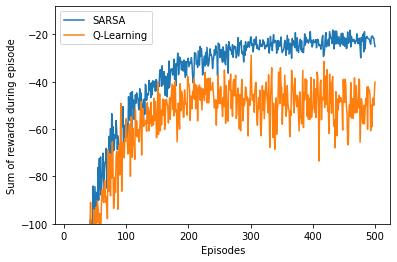

In [434]:
x_axis = np.arange(1,501)
sns.lineplot(x=x_axis[10:], y=s_agents_avg_rew_per_ep[10:])
sns.lineplot(x=x_axis[10:], y=q_agents_avg_rew_per_ep[10:])
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend(labels=['SARSA','Q-Learning'])
plt.ylim(bottom=-100)
plt.show;


In [278]:
#Creating the combined Q tables

In [279]:
s_agents_q_table = np.zeros(4*12*4).reshape(4,12,4)
q_agents_q_table = np.zeros(4*12*4).reshape(4,12,4)


In [280]:
for row in range(0,4):
    row_list =list()
    for col in range(0,12):
        col_list = list()
        for act in range(0,4):
            avg_q_vals = list()
            for agent in s_agent_list:
                avg_q_vals.append(agent.q_table[row,col,act])
            avg_q_val=sum(avg_q_vals)/len(avg_q_vals)
            col_list.append(avg_q_val)
        s_agents_q_table[row,col] = np.array(col_list)


In [281]:
for row in range(0,4):
    row_list =list()
    for col in range(0,12):
        col_list = list()
        for act in range(0,4):
            avg_q_vals = list()
            for agent in q_agent_list:
                avg_q_vals.append(agent.q_table[row,col,act])
            avg_q_val=sum(avg_q_vals)/len(avg_q_vals)
            col_list.append(avg_q_val)
        q_agents_q_table[row,col] = np.array(col_list)


In [282]:
dum_s_agent = Agent(.1,.1,[4,12],'S',all_actions)
dum_s_agent.q_table = s_agents_q_table

all_sxp, all_syp = dum_s_agent.return_trajectory(grid=fullenv)

In [283]:
dum_q_agent = Agent(.1,.1,[4,12],'Q',all_actions)
dum_q_agent.q_table = q_agents_q_table

all_qxp, all_qyp = dum_q_agent.return_trajectory(grid=fullenv)

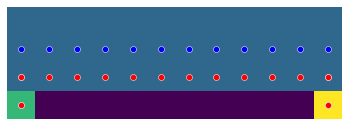

In [284]:
sns.scatterplot(x=all_sxp,y=all_syp, color='blue')
sns.scatterplot(x=all_qxp,y=all_qyp, color='red')
plt.imshow(fullenv.grid)
plt.axis('off')
plt.imshow;


In [285]:
### testing expected Sarsa

In [286]:
e_agent_list = list()
for i in range(0,100):
    e_agent_list.append(Agent(.1,.1,[4,12],'E',all_actions))   

In [287]:
e_agents_average_rewards = list()

In [288]:
for agent in range(0,len(e_agent_list)):
    while e_agent_list[agent].episode_count < 500:
        e_agent_list[agent].navigate_grid(grid=fullenv)

In [289]:
e_agents_avg_rew_per_ep = list()

In [290]:
for indic in range(0,500):
    sub_list = list()
    for agent in e_agent_list:
        sub_list.append(agent.total_rew_per_ep[indic])
    e_agents_avg_rew_per_ep.append(list(sub_list))

In [291]:
for i in range(0,len(e_agents_avg_rew_per_ep)):
    e_agents_avg_rew_per_ep[i] = sum(e_agents_avg_rew_per_ep[i])/len(e_agents_avg_rew_per_ep[i])

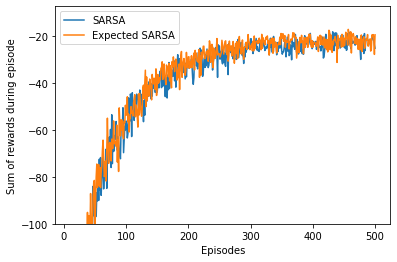

In [420]:
sns.lineplot(x=x_axis[10:500], y=s_agents_avg_rew_per_ep[10:])
#sns.lineplot(x=x_axis[10:], y=q_agents_avg_rew_per_ep[10:])
sns.lineplot(x=x_axis[10:500], y=e_agents_avg_rew_per_ep[10:])
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend(labels=['SARSA','Expected SARSA'])
plt.ylim(bottom=-100)
plt.show;


In [293]:
e_agents_q_table = np.zeros(4*12*4).reshape(4,12,4)



In [294]:
for row in range(0,4):
    row_list =list()
    for col in range(0,12):
        col_list = list()
        for act in range(0,4):
            avg_q_vals = list()
            for agent in e_agent_list:
                avg_q_vals.append(agent.q_table[row,col,act])
            avg_q_val=sum(avg_q_vals)/len(avg_q_vals)
            col_list.append(avg_q_val)
        e_agents_q_table[row,col] = np.array(col_list)


In [295]:
dum_e_agent = Agent(.1,.1,[4,12],'E',all_actions)
dum_e_agent.q_table = s_agents_q_table

all_exp, all_eyp = dum_e_agent.return_trajectory(grid=fullenv)

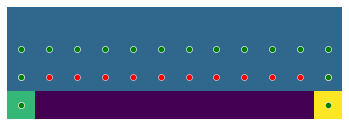

In [296]:
sns.scatterplot(x=all_sxp,y=all_syp, color='blue')
sns.scatterplot(x=all_qxp,y=all_qyp, color='red')
sns.scatterplot(x=all_exp,y=all_eyp, color='green')
plt.imshow(fullenv.grid)
plt.axis('off')
plt.imshow;


In [297]:
#### So it's very similar to regular SARSA under the alpha of .1
###checking at varying values of alpha

In [298]:
alphas = np.arange(2,21)/20
print(alphas)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95 1.  ]


In [299]:
e_avg_rew_per_alpha = list()
s_avg_rew_per_alpha = list()
q_avg_rew_per_alpha = list()
s_first_hund = list()
e_first_hund = list()
q_first_hund = list()


In [300]:
for i in range(0,len(alphas)):
    alpha_s_agent = Agent(.1,alphas[i], [4,12],'S',all_actions)
    alpha_e_agent = Agent(.1,alphas[i], [4,12],'E',all_actions)
    alpha_q_agent = Agent(.1,alphas[i], [4,12],'Q',all_actions)

    while alpha_s_agent.episode_count < 5000:
        alpha_s_agent.navigate_grid(grid=fullenv)

    while alpha_e_agent.episode_count < 5000:
        alpha_e_agent.navigate_grid(grid=fullenv)

    while alpha_q_agent.episode_count < 5000:
        alpha_q_agent.navigate_grid(grid=fullenv)

    avg_s_rew = sum(alpha_s_agent.total_rew_per_ep[100:])/4900
    avg_e_rew = sum(alpha_e_agent.total_rew_per_ep[100:])/4900
    avg_q_rew = sum(alpha_q_agent.total_rew_per_ep[100:])/4900

    s_first_hund_avg = sum(alpha_s_agent.total_rew_per_ep[:100])/100
    e_first_hund_avg = sum(alpha_e_agent.total_rew_per_ep[:100])/100
    q_first_hund_avg = sum(alpha_q_agent.total_rew_per_ep[:100])/100

    s_avg_rew_per_alpha.append(avg_s_rew)
    e_avg_rew_per_alpha.append(avg_e_rew)
    q_avg_rew_per_alpha.append(avg_q_rew)

    s_first_hund.append(s_first_hund_avg)
    e_first_hund.append(e_first_hund_avg)
    q_first_hund.append(q_first_hund_avg)


    


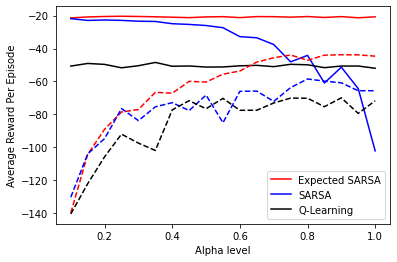

In [301]:
sns.lineplot(x=alphas, y=e_avg_rew_per_alpha, color = 'red')
sns.lineplot(x=alphas, y=s_avg_rew_per_alpha, color = 'blue')
sns.lineplot(x=alphas, y=q_avg_rew_per_alpha, color = 'black')

sns.lineplot(x=alphas, y=e_first_hund, color = 'red', linestyle='--')
sns.lineplot(x=alphas, y=s_first_hund, color = 'blue', linestyle='--')
sns.lineplot(x=alphas, y=q_first_hund, color = 'black', linestyle='--')

plt.xlabel('Alpha level')
plt.ylabel('Average Reward Per Episode')
plt.legend(labels=['Expected SARSA', 'SARSA', 'Q-Learning'])
plt.show;

In [302]:
epsilons = np.arange(2,11)/20
print(epsilons)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [431]:
epsilon_s_agents = list()
for i in range(0,len(epsilons)):
    epsilon_s_agents.append(Agent(epsilons[i], .1,[4,12],'S',all_actions))


In [432]:
np.random.seed(220)
for agent in epsilon_s_agents:
    while agent.episode_count < 1000:
        agent.navigate_grid(grid=fullenv)


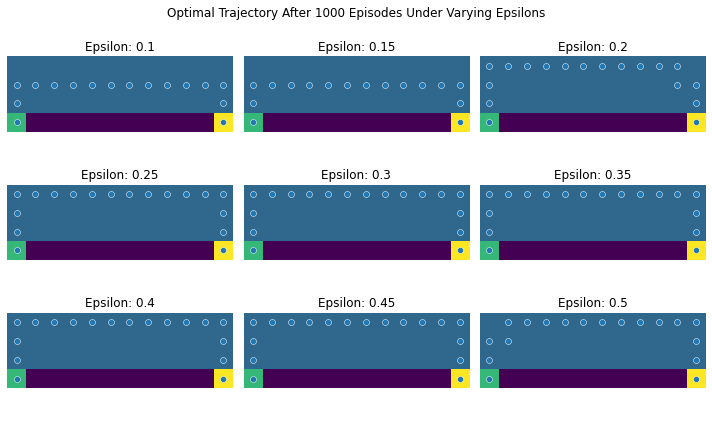

In [433]:
fig = plt.figure(figsize=(10,6))
rows = 3
cols = 3
plt.title('Optimal Trajectory After 1000 Episodes Under Varying Epsilons')
plt.axis('off')

for i in range(0,9):
    fig.add_subplot(rows,cols, i+1)
    xp, yp = epsilon_s_agents[i].return_trajectory(grid=fullenv)
    sns.scatterplot(x=xp, y=yp)
    plt.imshow(fullenv.grid)
    plt.axis('off')
    plt.title(f'Epsilon: {epsilons[i]}')


plt.tight_layout()

